In [1]:
# General modules
import sys
import os
import session_info
import warnings
from pyprojroot.here import here
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from tqdm import tqdm
# Specific modules
import scanpy as sc
import anndata as ad
import scienceplots

# Setting some parameters
warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

# Import functions
from customPythonFunctions import balanced_sample

plt.style.use(['nature'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

overwriteFigures = True
overwriteData = True

pd.options.display.max_columns=300
pd.options.display.max_rows = 1000

**Defining functions**

In [2]:
def qc_gex_projectlibrary(adata):
    import numpy as np
    import pandas as pd
    import anndata
    
    # Group the data by "project" and "library" using pandas
    grouped = adata.obs.groupby(["libraryID"])
    
    # Create an empty list to store the summary table rows
    summary_rows = []

    # Iterate over each group
    for (libraryID), group_data in grouped:
        
        # Calculate the median values within the group
        chemistry = np.unique(group_data["chemistry"])
        num_cells = group_data["libraryID"].size
        median_counts = np.median(group_data["total_counts"])
        median_features = np.median(group_data["n_genes_by_counts"])
        median_mt_pct = np.median(group_data["pct_counts_mt"])
        median_ribo_pct = np.median(group_data["pct_counts_ribo"])
        median_hb_pct = np.median(group_data["pct_counts_hb"])
        median_plt_pct = np.median(group_data["pct_counts_plt"])
    
        # Create a summary row with the group information and median values
        summary_row = {
            "libraryID": libraryID,
            "chemistry": chemistry,
            "Number of cells": int(num_cells),
            "Median UMI counts": int(median_counts),
            "Median Genes": int(median_features),
            "Median MT %": round(median_mt_pct, 2),
            "Median RB %": round(median_ribo_pct,2),
            "Median HB %": round(median_hb_pct,2),
            "Median PLT %": round(median_plt_pct,2),
        }

        # Append the summary row to the list
        summary_rows.append(summary_row)

    # Create a DataFrame from the summary rows
    summary_table = pd.DataFrame(summary_rows)
    return summary_table
    
def qc_gene_expression_per_study(adata, gene_list = None, save_name=None, fig_size = (20,4)):
    import numpy as np
    import pandas as pd
    import anndata
    import sys
    import seaborn as sns
    
    if gene_list is None:
        gene_list = adata.var_names
    
    res = pd.DataFrame(columns=gene_list, index=adata.obs['studyID'].unique())
    
    for source in adata.obs['studyID'].unique(): 
        res.loc[source] = adata[adata.obs['studyID'].isin([source]),gene_list].X.mean(0)
    
    BinRes = res.copy()
    BinRes[BinRes > 0 ] = 1.0
    
    sys.setrecursionlimit(50000)
    sns.clustermap(BinRes.astype(float), z_score=None, figsize=fig_size)

    if save_name:
        plt.savefig(here(save_name), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    plt.show()

In [3]:
print("Main directory path: {}".format(here()))

# create result directories
os.makedirs(here('01_data_processing/results/extended_obs'), exist_ok = True)
os.makedirs(here('01_data_processing/figures'), exist_ok=True)

Main directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas-R1


**Load data**

In [4]:
# Load the h5ad file
infile_path = here("01_data_processing/results/01_INFLAMMATION_external.h5ad")
adata = sc.read_h5ad(infile_path)
adata

AnnData object with n_obs × n_vars = 600032 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

In [5]:
adata.obs.head()

studyID       libraryID  \
cellID                                                                  
SCGT00val_L006_I036016_T0_AAACCCAAGACAACTA  SCGT00val  SCGT00val_L006   
SCGT00val_L006_I036023_T0_AAACCCAAGACGGAAA  SCGT00val  SCGT00val_L006   
SCGT00val_L006_I036016_T0_AAACCCAAGAGCATTA  SCGT00val  SCGT00val_L006   
SCGT00val_L006_I036021_T0_AAACCCAAGATGGTCG  SCGT00val  SCGT00val_L006   
SCGT00val_L006_I036021_T0_AAACCCAAGCAACAAT  SCGT00val  SCGT00val_L006   

                                                        sampleID chemistry  \
cellID                                                                       
SCGT00val_L006_I036016_T0_AAACCCAAGACAACTA  SCGT00val_I036016_T0  3_GEX_V3   
SCGT00val_L006_I036023_T0_AAACCCAAGACGGAAA  SCGT00val_I036023_T0  3_GEX_V3   
SCGT00val_L006_I036016_T0_AAACCCAAGAGCATTA  SCGT00val_I036016_T0  3_GEX_V3   
SCGT00val_L006_I036021_T0_AAACCCAAGATGGTCG  SCGT00val_I036021_T0  3_GEX_V3   
SCGT00val_L006_I036021_T0_AAACCCAAGCAACAAT  SCGT00val_I036021_T0  3_GEX_V3   

                                                     technology  \
cellID                                                            
SCGT00val_L006_I036016_T0_AAACCCAAGACAACTA  3_GEX_V3_GenoHashed   
SCGT00val_L006_I036023_T0_AAACCCAAGACGGAAA  3_GEX_V3_GenoHashed   
SCGT00val_L006_I036016_T0_AAACCCAAGAGCATTA  3_GEX_V3_GenoHashed   
SCGT00val_L006_I036021_T0_AAACCCAAGATGGTCG  3_GEX_V3_GenoHashed   
SCGT00val_L006_I036021_T0_AAACCCAAGCAACAAT  3_GEX_V3_GenoHashed   

                                                    patientID disease  \
cellID                                                                  
SCGT00val_L006_I036016_T0_AAACCCAAGACAACTA  SCGT00val_I036016      RA   
SCGT00val_L006_I036023_T0_AAACCCAAGACGGAAA  SCGT00val_I036023      RA   
SCGT00val_L006_I036016_T0_AAACCCAAGAGCATTA  SCGT00val_I036016      RA   
SCGT00val_L006_I036021_T0_AAACCCAAGATGGTCG  SCGT00val_I036021      RA   
SCGT00val_L006_I036021_T0_AAACCCAAGCAACAAT  SCGT00val_I036021      RA   

                                            timepoint_replicate  \
cellID                                                            
SCGT00val_L006_I036016_T0_AAACCCAAGACAACTA                  0.0   
SCGT00val_L006_I036023_T0_AAACCCAAGACGGAAA                  0.0   
SCGT00val_L006_I036016_T0_AAACCCAAGAGCATTA                  0.0   
SCGT00val_L006_I036021_T0_AAACCCAAGATGGTCG                  0.0   
SCGT00val_L006_I036021_T0_AAACCCAAGCAACAAT                  0.0   

                                           treatmentStatus therapyResponse  \
cellID                                                                       
SCGT00val_L006_I036016_T0_AAACCCAAGACAACTA             TNF              NR   
SCGT00val_L006_I036023_T0_AAACCCAAGACGGAAA             TNF              NR   
SCGT00val_L006_I036016_T0_AAACCCAAGAGCATTA             TNF              NR   
SCGT00val_L006_I036021_T0_AAACCCAAGATGGTCG             TNF               R   
SCGT00val_L006_I036021_T0_AAACCCAAGCAACAAT             TNF               R   

                                               sex   age    BMI binned_age  \
cellID                                                                       
SCGT00val_L006_I036016_T0_AAACCCAAGACAACTA  female  33.0  28.72      31-40   
SCGT00val_L006_I036023_T0_AAACCCAAGACGGAAA  female  52.0  22.68      51-60   
SCGT00val_L006_I036016_T0_AAACCCAAGAGCATTA  female  33.0  28.72      31-40   
SCGT00val_L006_I036021_T0_AAACCCAAGATGGTCG  female  61.0  24.61      61-70   
SCGT00val_L006_I036021_T0_AAACCCAAGCAACAAT  female  61.0  24.61      61-70   

                                           diseaseStatus smokingStatus  \
cellID                                                                   
SCGT00val_L006_I036016_T0_AAACCCAAGACAACTA            na  never-smoker   
SCGT00val_L006_I036023_T0_AAACCCAAGACGGAAA            na  never-smoker   
SCGT00val_L006_I036016_T0_AAACCCAAGAGCATTA            na  never-smoker   
SCGT00val_L006_I036021_T0_AAACCCAAGATGGTCG            na  never-smoker 

In [6]:
adata.var.head()

hgnc_id  symbol     locus_group HUGO_status
ensembl_gene_id                                                
ENSG00000000003  HGNC:11858  TSPAN6  protein_coding    official
ENSG00000000005  HGNC:17757    TNMD  protein_coding    official
ENSG00000000419   HGNC:3005    DPM1  protein_coding    official
ENSG00000000457  HGNC:19285   SCYL3  protein_coding    official
ENSG00000000460  HGNC:25565   FIRRM  protein_coding    official

**Load metadata**

In [7]:
datasetDF = pd.read_csv(here('01_data_processing/datasets/INFLAMMATION_ATLAS_datasets_curated.csv'))
datasetDF.set_index('studyID', inplace=True)
datasetDF

diseaseGroup  \
studyID                                                      
SCGT00                                    homeostasis;IMID   
SCGT00val                                             IMID   
SCGT01                                         homeostasis   
SCGT02                    homeostasis;chronic_inflammation   
SCGT03                                        solid_tumors   
SCGT04                                chronic_inflammation   
SCGT05                                        solid_tumors   
SCGT06                               homeostasis;infection   
Reyes2020                   homeostasis;acute_inflammation   
Cillo2020                         homeostasis;solid_tumors   
Zhang2023                            homeostasis;infection   
Schafflick2020                            homeostasis;IMID   
Liu2021                                       solid_tumors   
Palshikar2022                                    infection   
Terekhova2023                                  homeostasis   
Perez2022                                 homeostasis;IMID   
Ramachandran2019                      chronic_inflammation   
Martin2019                                            IMID   
Wang2020                             homeostasis;infection   
Savage2021                                homeostasis;IMID   
Jiang2020                               acute_inflammation   
Mistry2019                                            IMID   
COMBAT2022        homeostasis;infection;acute_inflammation   
Ren2021                              homeostasis;infection   
10XGenomics                                    homeostasis   

                                           disease dataSource  \
studyID                                                         
SCGT00            HC;RA;PsA;IBDs_CD;IBDs_UC;PS;SLE    inhouse   
SCGT00val                                       RA    inhouse   
SCGT01                                          HC    inhouse   
SCGT02                              HC;Asthma;COPD    inhouse   
SCGT03                                        BRCA    inhouse   
SCGT04                                   cirrhosis    inhouse   
SCGT05                                         CRC    inhouse   
SCGT06                                    HC;COVID    inhouse   
Reyes2020                                HC;sepsis     public   
Cillo2020                                 HC;HNSCC     public   
Zhang2023                                   HC;HBV     public   
Schafflick2020                               HC;MS     public   
Liu2021                                        NPC     public   
Palshikar2022                                  HIV     public   
Terekhova2023                                   HC     public   
Perez2022                                   HC;SLE     public   
Ramachandran2019                         cirrhosis     public   
Martin2019                                 IBDs_CD     public   
Wang2020                                    HC;HIV     public   
Savage2021                                  HC;SLE     public   
Jiang2020                                   sepsis     public   
Mistry2019                                     SLE     public   
COMBAT2022                     HC;COVID;Flu;sepsis     public   
Ren2021                                   HC;COVID     public   
10XGenomics                                     HC     public   

                                                      h5ad_FileName  \
studyID                                                               
SCGT00            INFLAMMATION_DOCTIS_week0_bothChemistry_merged...   
SCGT00val           INFLAMMATION_DOCTISvalidation_week0_merged.h5ad   
SCGT01                          INFLAMMATION_EXERCISEHC_merged.h5ad   
SCGT02                      INFLAMMATION_ASTHMA-COPD-HC_merged.h5ad   
SCGT03                          INFLAMMATION_BRCA_time0_merged.h5ad   
SCGT04                           INFLAMMATION_CIRRHOSIS_merged.h5ad   
SCGT05                                 INFLAMMA

# Quality control

## Compute QC covariates

First, we will compute the QC covariates (fraction of mitochondrial, ribosomal and hemoglobine genes) on our data.

In [8]:
# mitochondrial genes
adata.var["mt"] = adata.var["symbol"].str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var["symbol"].str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var["symbol"].str.contains("^HB[^(P)]")
# platelet genes
adata.var["plt"] = adata.var["symbol"].isin(["PPBP", "PDGF", "ANG1", "LAPTM4B", "WASF3", "TPM3", "PF4", "TAC1"])

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb", "plt"], inplace=True, percent_top=[20], log1p=True)
adata

AnnData object with n_obs × n_vars = 600032 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [9]:
pd.set_option('display.max_rows', None)
qc_gex_df = qc_gex_projectlibrary(adata)
display(qc_gex_df)

pd.reset_option('display.max_rows')

libraryID   chemistry  Number of cells  Median UMI counts  \
0        (10XGenomics_L000,)  [3_GEX_V3]             3996               7476   
1        (10XGenomics_L001,)  [3_GEX_V3]             4343               4683   
2        (10XGenomics_L002,)  [3_GEX_V3]             3367               7137   
3        (10XGenomics_L003,)  [3_GEX_V3]             4052               5861   
4        (10XGenomics_L004,)  [3_GEX_V3]             5083               5784   
5        (10XGenomics_L005,)  [3_GEX_V3]            23837               6520   
6        (10XGenomics_L006,)  [3_GEX_V3]            11485               6123   
7        (10XGenomics_L007,)  [3_GEX_V3]            11996               6892   
8        (10XGenomics_L008,)  [5_GEX_V2]            23643               4825   
9          (Jiang2020_L000,)  [3_GEX_V2]             4886               2294   
10         (Jiang2020_L001,)  [3_GEX_V2]             3797               2237   
11         (Jiang2020_L002,)  [3_GEX_V2]             2239               2793   
12         (Jiang2020_L003,)  [3_GEX_V2]             4043               2961   
13         (Jiang2020_L004,)  [3_GEX_V2]             3861               2992   
14         (Jiang2020_L005,)  [3_GEX_V2]             3972               3674   
15         (Jiang2020_L006,)  [3_GEX_V2]             4153               2872   
16        (Martin2019_L000,)  [3_GEX_V2]             2253               2301   
17        (Martin2019_L001,)  [3_GEX_V2]             1087               3428   
18        (Martin2019_L002,)  [3_GEX_V2]             1414               2494   
19        (Martin2019_L003,)  [3_GEX_V2]             3164               3051   
20        (Martin2019_L004,)  [3_GEX_V2]             4632               2992   
21        (Martin2019_L005,)  [3_GEX_V2]             6432               1970   
22        (Martin2019_L006,)  [3_GEX_V2]            14421               2680   
23        (Martin2019_L007,)  [3_GEX_V2]             5446               3012   
24        (Mistry2019_L000,)  [3_GEX_V2]             7865               1977   
25        (Mistry2019_L001,)  [3_GEX_V2]             8481               1584   
26        (Mistry2019_L002,)  [3_GEX_V2]             8043               2618   
27     (Palshikar2022_L000,)  [3_GEX_V2]            13787               2494   
28  (Ramachandran2019_L000,)  [3_GEX_V2]             8921               3054   
29  (Ramachandran2019_L001,)  [3_GEX_V2]             6636               2849   
30  (Ramachandran2019_L002,)  [3_GEX_V2]             8140               3081   
31  (Ramachandran2019_L003,)  [3_GEX_V2]             7067               4018   
32         (SCGT00val_L000,)  [3_GEX_V3]            29868               3712   
33         (SCGT00val_L001,)  [3_GEX_V3]            29334               3674   
34         (SCGT00val_L002,)  [3_GEX_V3]            26638               4215   
35         (SCGT00val_L003,)  [3_GEX_V3]            27004               4266   
36         (SCGT00val_L004,)  [3_GEX_V3]            31579               3616   
37         (SCGT00val_L005,)  [3_GEX_V3]            28178               3757   
38         (SCGT00val_L006,)  [3_GEX_V3]            29916               3588   
39         (SCGT00val_L007,)  [3_GEX_V3]            26569               3551   
40            (SCGT06_L000,)  [3_GEX_V3]            25745               4018   
41            (SCGT06_L001,)  [3_GEX_V3]            39051               3061   
42        (Savage2021_L000,)  [3_GEX_V3]             9011               6641   
43        (Savage2021_L001,)  [3_GEX_V3]             9537               6476   
44        (Savage2021_L002,)  [3_GEX_V3]             9862               6317   
45        (Savage2021_L003,)  [3_GEX_V3]            10112               7303   
46        (Savage2021_L004,)  [3_GEX_V3]             9309               7068   
47        (Savage2021_L005,)  [3_GEX_V3]             9477               6944   
48        (Savage2021_L006,)  [3_GEX_V3]            11722               7138   
49        (Savage20

# Quality control at LIBRARY level

After exploring general library QC metrics, we decided to filter out the libraries with very low quality, considering the total number of cells (standard 10X channel is designed to target 2-10K cells) and the median number of total genes (recovering information for very few genes might become a problem in the downstream analysis steps). 

In [10]:
# QC thresholds
min_cells_by_lib = 500
min_meangenes_by_lib = 500

In [11]:
# Removing libraries with very low total number of cells

# Calculate the value counts for each 'libraryID'
library_cells = adata.obs["libraryID"].value_counts()

# Get the library names to remove
libraries_to_remove = library_cells[library_cells < min_cells_by_lib].index

if len(libraries_to_remove) > 0:
    print('Libraries removed:')
    print(libraries_to_remove.astype(str))

    # Filter the 'adata' object
    adata = adata[~adata.obs["libraryID"].isin(libraries_to_remove.astype(str))]
else:
    print('No library is removed')

No library is removed


In [12]:
# Removing libraries with very low median number of total genes

# Calculate the median total counts for each 'libraryID'
library_median_counts = adata.obs.groupby("libraryID")["n_genes_by_counts"].median()

# Get the library names with median "total_counts" fewer than 500
libraries_to_remove = library_median_counts[library_median_counts < min_meangenes_by_lib].index

if len(libraries_to_remove) > 0:
    print('Libraries removed:')
    print(libraries_to_remove.astype(str))

    # Filter the 'adata' object
    adata = adata[~adata.obs["libraryID"].isin(libraries_to_remove.astype(str))]
else:
    print('No library is removed')

No library is removed


# Quality control at CELL level

We aim to remove low-quality cells from the dataset focusing on the main three QC metrics, but also two additional QC covariates interesting:

1. Library size: Number of counts or UMIs per barcode
2. Library complexity: Number of genes per barcode
3. Fraction of counts from mitochondrial genes per barcode
4. (Fraction of counts from ribosomal genes per barcode)
5. (Fraction of counts from hemoglobine genes per barcode)

Following best practices: https://www.sc-best-practices.org/preamble.html

Luecken, M. D., & Theis, F. J. (2019). Current best practices in single‐cell RNA‐seq analysis: a tutorial. Molecular systems biology, 15(6), e8746

## Assessing QC information

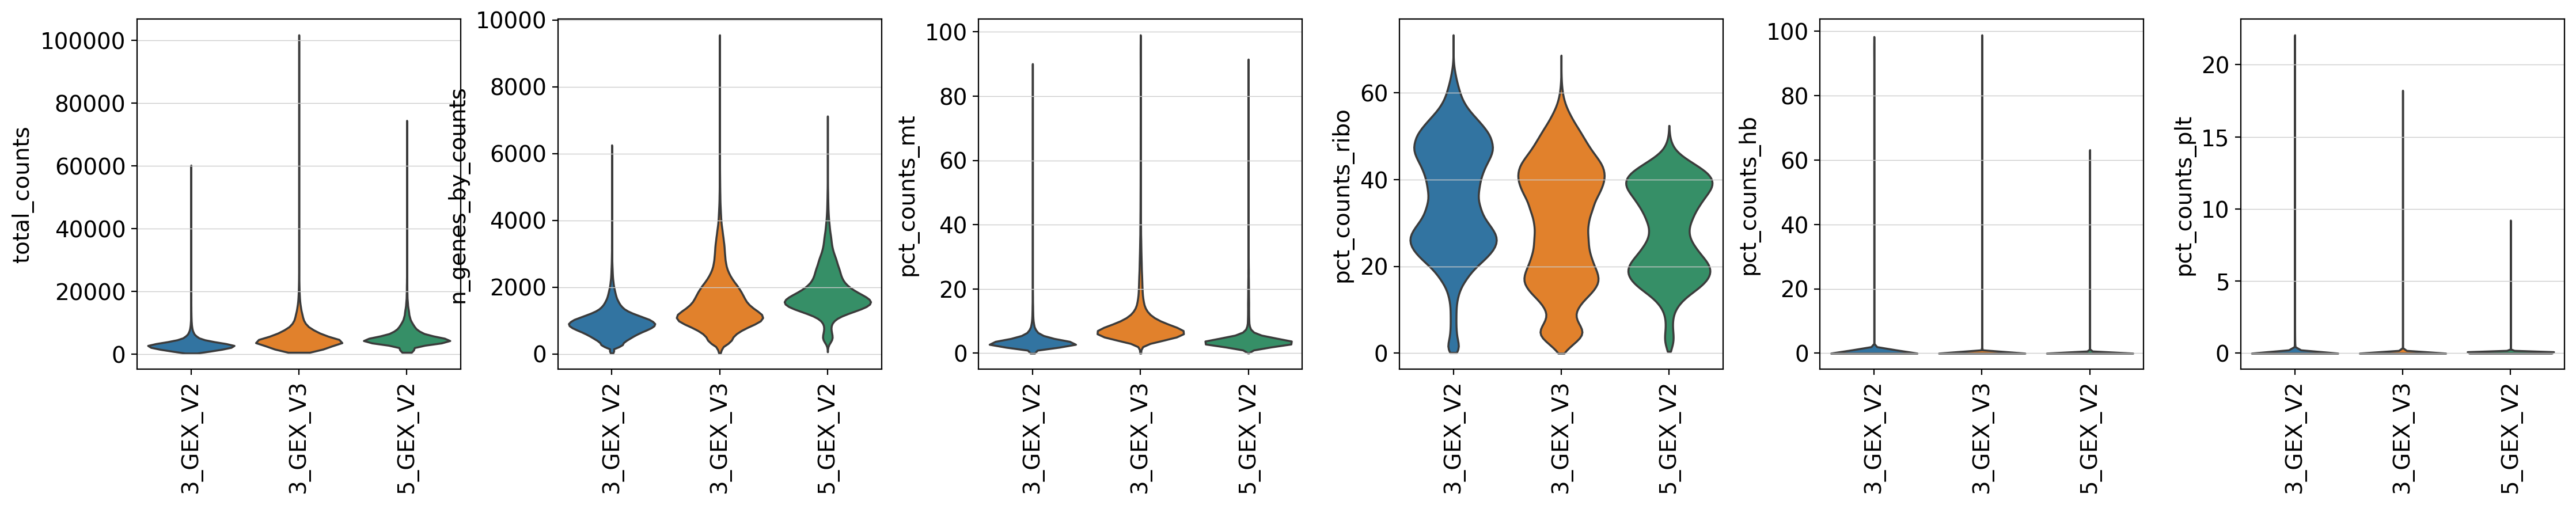

<Figure size 400x400 with 0 Axes>

In [13]:
sc.pl.violin(
    adata, 
    [
     'total_counts', 
     'n_genes_by_counts', 
     'pct_counts_mt',
     'pct_counts_ribo',
     'pct_counts_hb',
     'pct_counts_plt'
    ],
    groupby="chemistry", 
    stripplot=False, rotation = 90,
)

if overwriteFigures:
    plt.savefig(here('01_data_processing/figures/02_QCexternal_totalCount_by_chemistry.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    
plt.show()

In [14]:
preFilterCellsIdx = adata.obs.studyID.isin(datasetDF.loc[datasetDF.expectedDoubletRate == '0'].index.tolist())

with plt.rc_context({'figure.figsize':(10,6)}):
    cellIdx = (adata.obs.chemistry == "3_GEX_V3") & (preFilterCellsIdx)
    if np.sum(cellIdx) > 0:
        print('prefiltered studies | 3_GEX_V3')
        sc.pl.violin(adata[cellIdx, :],
                     keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
                     groupby='libraryID', 
                     stripplot=False,
                     rotation=90, show = False,
                     #title="3_GEX_V3"
                    )
        if overwriteFigures:
            plt.savefig(here('01_data_processing/figures/02_QCexcluded_metrics_3GEXV3cleaned_totCount_byLibrary.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
        plt.show()
        
    cellIdx = (adata.obs.chemistry == "3_GEX_V3") & (~preFilterCellsIdx)
    if np.sum(cellIdx) > 0:
        print('NON prefiltered studies | 3_GEX_V3')
        sc.pl.violin(adata[cellIdx, :],
                     keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
                     groupby='libraryID', 
                     stripplot=False,
                     rotation=90,
                     # title="3_GEX_V3"
                    )
        if overwriteFigures:
            plt.savefig(here('01_data_processing/figures/02_QCexcluded_metrics_3GEXV3notCleaned_totCount_byLibrary.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
        plt.show()    
    
    
    cellIdx = (adata.obs.chemistry == "3_GEX_V2") & (preFilterCellsIdx)
    if np.sum(cellIdx) > 0:
        print('prefiltered studies | 3_GEX_V2')
        sc.pl.violin(adata[cellIdx, :], 
                     keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
                     groupby='libraryID', 
                     stripplot=False,
                     rotation=90,
                     # title="3_GEX_V2"
                    )
        if overwriteFigures:
            plt.savefig(here('01_data_processing/figures/02_QCexcluded_metrics_3GEXV2cleaned_totCount_byLibrary.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
        plt.show()
        
    cellIdx = (adata.obs.chemistry == "3_GEX_V2") & (~preFilterCellsIdx)
    if np.sum(cellIdx) > 0:
        print('NON prefiltered studies | 3_GEX_V2')    
        sc.pl.violin(adata[cellIdx, :], 
                     keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
                     groupby='libraryID', 
                     stripplot=False,
                     rotation=90,
                     # title="3_GEX_V2"
                    )
        if overwriteFigures:
            plt.savefig(here('01_data_processing/figures/02_QCexcluded_metrics_3GEXV2notCleaned_totCount_byLibrary.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
        plt.show()    
    
    
    # 5_GEX 
    cellIdx = (adata.obs.chemistry == "5_GEX_V1") & (preFilterCellsIdx)
    if np.sum(cellIdx) > 0:
        print('prefiltered studies | 5_GEX_V1')
        sc.pl.violin(adata[cellIdx, :], 
                     keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
                     groupby='libraryID', 
                     stripplot=False,
                     rotation=90,
                     # title="5_GEX_V1cleaned"
                    )
        if overwriteFigures:
            plt.savefig(here('01_data_processing/figures/02_QCexcluded_metrics_5_GEX_V1cleaned_totCount_byLibrary.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
        plt.show()

    cellIdx = (adata.obs.chemistry == "5_GEX_V1") & (~preFilterCellsIdx)
    if np.sum(cellIdx) > 0:
        print('NON prefiltered studies | 5_GEX_V1')
        sc.pl.violin(adata[cellIdx, :], 
                     keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
                     groupby='libraryID', 
                     stripplot=False,
                     rotation=90,
                     # title="5_GEX_V1notCleaned"
                    )
        if overwriteFigures:
            plt.savefig(here('01_data_processing/figures/02_QCexcluded_metrics_5_GEX_V1notCleaned_totCount_byLibrary.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
        plt.show() 
    
        
    cellIdx = (adata.obs.chemistry == "5_GEX_V2") & (preFilterCellsIdx)
    if np.sum(cellIdx) > 0:    
        print('prefiltered studies | 5_GEX_V2')
        sc.pl.violin(adata[cellIdx, :],
                 keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
                 groupby='libraryID', 
                 stripplot=False,
                 rotation=90,
                 # title="5_GEX_V2cleaned"
                )
        if overwriteFigures:
            plt.savefig(here('01_data_processing/figures/02_QCexcluded_metrics_5_GEX_V2cleaned_totCount_byLibrary.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
        plt.show()

    cellIdx = (adata.obs.chemistry == "5_GEX_V2") & (~preFilterCellsIdx)
    if np.sum(cellIdx) > 0:    
        print('NON prefiltered studies | 5_GEX_V2')
        sc.pl.violin(adata[cellIdx, :],
                     keys=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'], 
                     groupby='libraryID', 
                     stripplot=False,
                     rotation=90,
                     # title="5_GEX_V2notCleaned"
                    )
        if overwriteFigures:
            plt.savefig(here('01_data_processing/figures/02_QCexcluded_metrics_5_GEX_V2notCleaned_totCount_byLibrary.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
        plt.show()  

NON prefiltered studies | 3_GEX_V3


<Figure size 1000x600 with 0 Axes>

NON prefiltered studies | 3_GEX_V2


<Figure size 1000x600 with 0 Axes>

NON prefiltered studies | 5_GEX_V2


<Figure size 1000x600 with 0 Axes>

Next, we visualize the QC variables across libraries (considering the library' chemistry) and assess their overall quality based on the metrics to decide how to proceed with the QC step.

In [15]:
sns.displot(data=adata.obs, x="total_counts", col="chemistry", col_wrap=2, facet_kws={"sharex": False, "sharey": False})
if overwriteFigures:
    plt.savefig(here('01_data_processing/figures/02_QCexternal_metrics_displot_totalcounts_bychemistry.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
plt.show()


sns.displot(data=adata.obs, x="n_genes_by_counts", col="chemistry", col_wrap=2, facet_kws={"sharex": False, "sharey": False})
if overwriteFigures:
    plt.savefig(here('01_data_processing/figures/02_QCexternal_metrics_displot_genesbycounts_bychemistry.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
plt.show()


sns.displot(data=adata.obs, x="pct_counts_mt", col="chemistry", col_wrap=2, facet_kws={"sharex": False, "sharey": False})
if overwriteFigures:
    plt.savefig(here('01_data_processing/figures/02_QCexternal_metrics_displot_pctmt_bychemistry.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
plt.show()

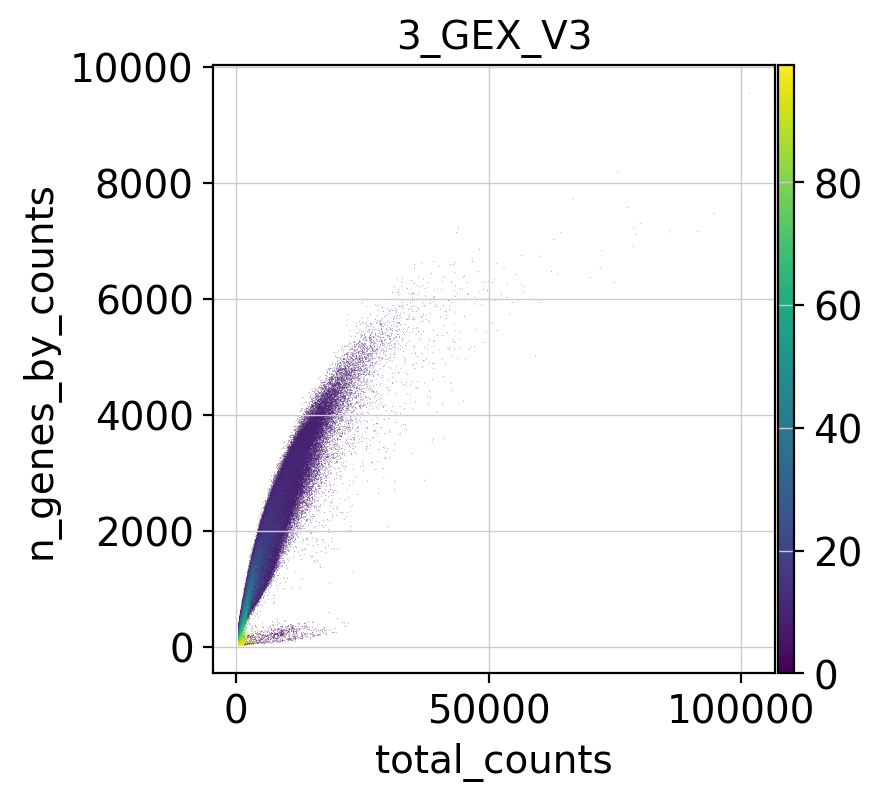

<Figure size 400x400 with 0 Axes>

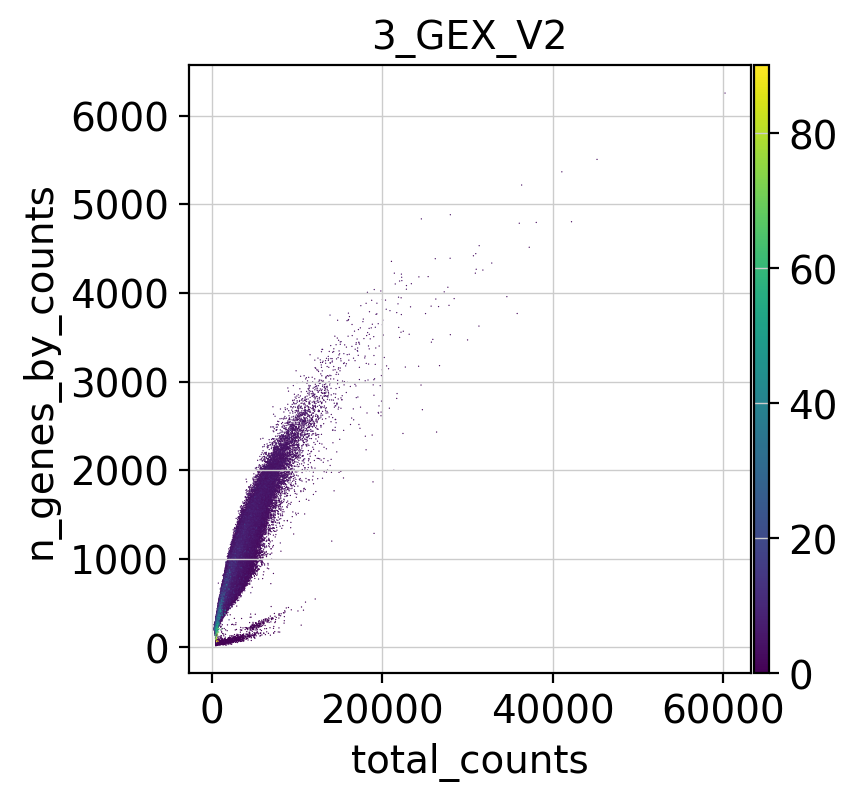

<Figure size 400x400 with 0 Axes>

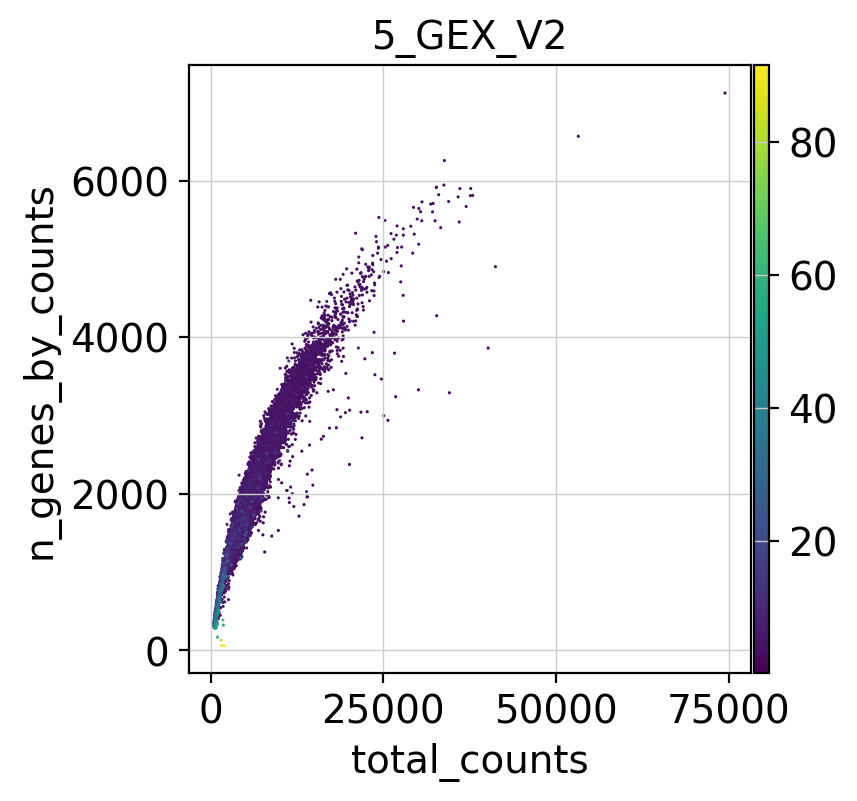

<Figure size 400x400 with 0 Axes>

In [16]:
cellIdx = (adata.obs.chemistry == "3_GEX_V3")
if np.sum(cellIdx) > 0:
    sc.pl.scatter(adata[cellIdx, :],
                  "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="3_GEX_V3")
    if overwriteFigures:
        plt.savefig(here('01_data_processing/figures/02_QCexternal_joinmetrics_3GEXV3_beforeFiltering.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    plt.show()

cellIdx = (adata.obs.chemistry == "3_GEX_V2")
if np.sum(cellIdx) > 0:
    sc.pl.scatter(adata[cellIdx, :],
              "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="3_GEX_V2")
    if overwriteFigures:
        plt.savefig(here('01_data_processing/figures/02_QCexternal_joinmetrics_3GEXV2_beforeFiltering.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    plt.show()

cellIdx = (adata.obs.chemistry == "5_GEX_V2")
if np.sum(cellIdx) > 0:
    sc.pl.scatter(adata[cellIdx, :],
                  "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="5_GEX_V2")
    if overwriteFigures:
        plt.savefig(here('01_data_processing/figures/02_QCexternal_joinmetrics_5GEXV2_beforeFiltering.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    plt.show()

cellIdx = (adata.obs.chemistry == "5_GEX_V1")
if np.sum(cellIdx) > 0:
    sc.pl.scatter(adata[cellIdx, :],
                  "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="5_GEX_V1")
    if overwriteFigures:
        plt.savefig(here('01_data_processing/figures/02_QCexternal_joinmetrics_5GEXV1_beforeFiltering.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    plt.show()

After examining the previous results, we can see that the distribution of the three main QC covariates is really similar within the libraries generated using the same chemistry, and considering some datasets have already gone through a prior QC. For this reason, we will not perform a common QC for all of them, but split them by chemistry. 

It is important not to consider the QC covariates independently as this can lead to the misinterpretation of results, but to jointly explore how the three main metrics covary in order to set univariate QC thresholds. Additionally, it is also recommended to be quite permissive at this step and remove only very low quality cells, and later on, perform a second QC with more accurate and restrictive parameters (e.g. at the cell-lineage level).

<Figure size 400x400 with 0 Axes>

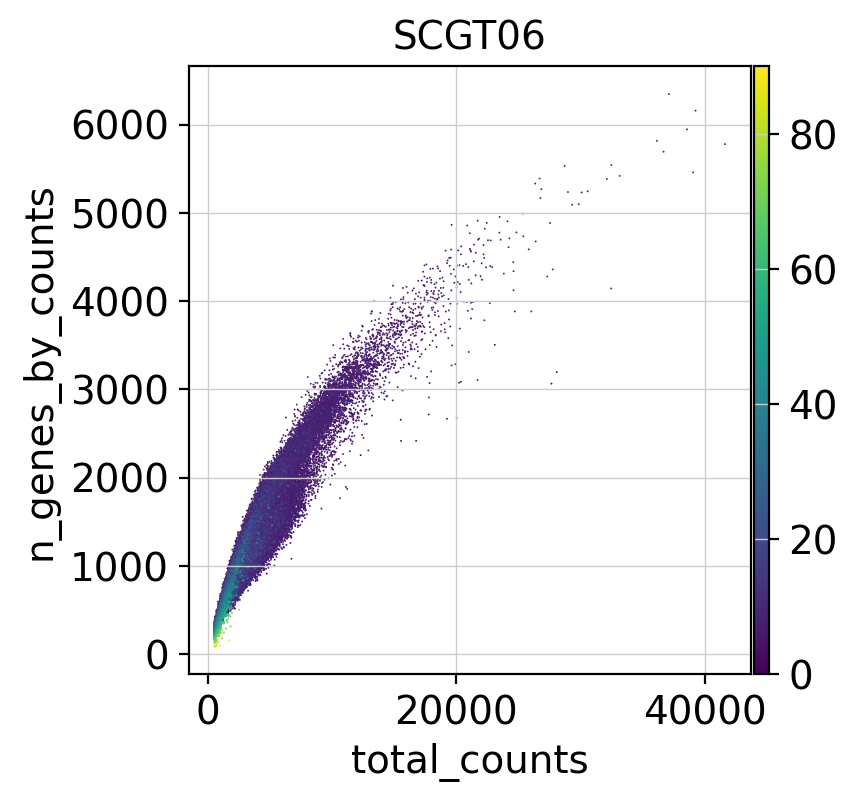

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

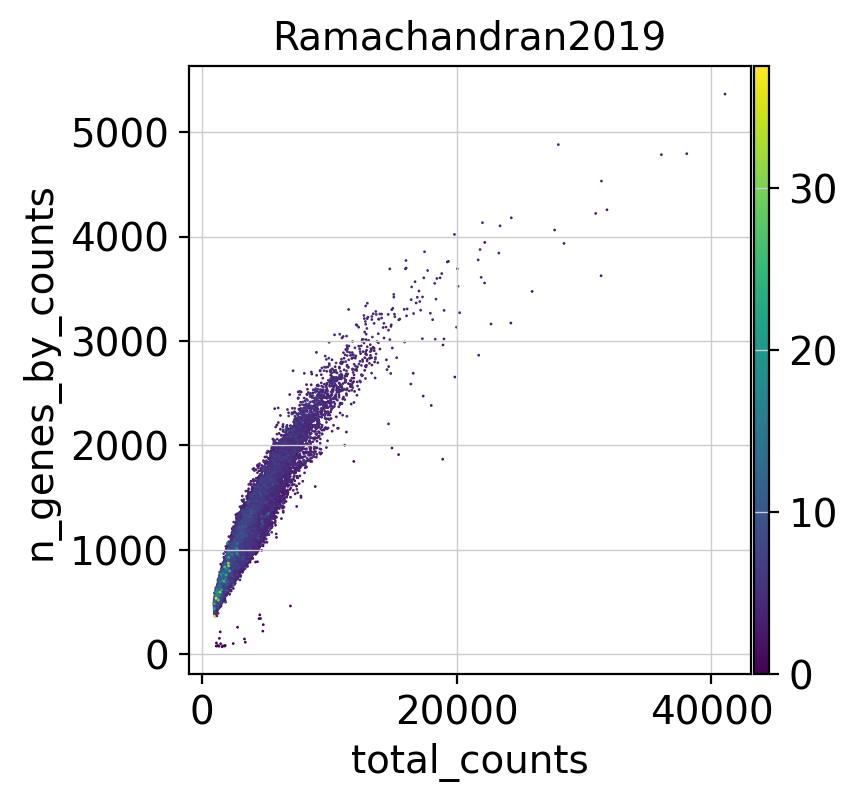

<Figure size 400x400 with 0 Axes>

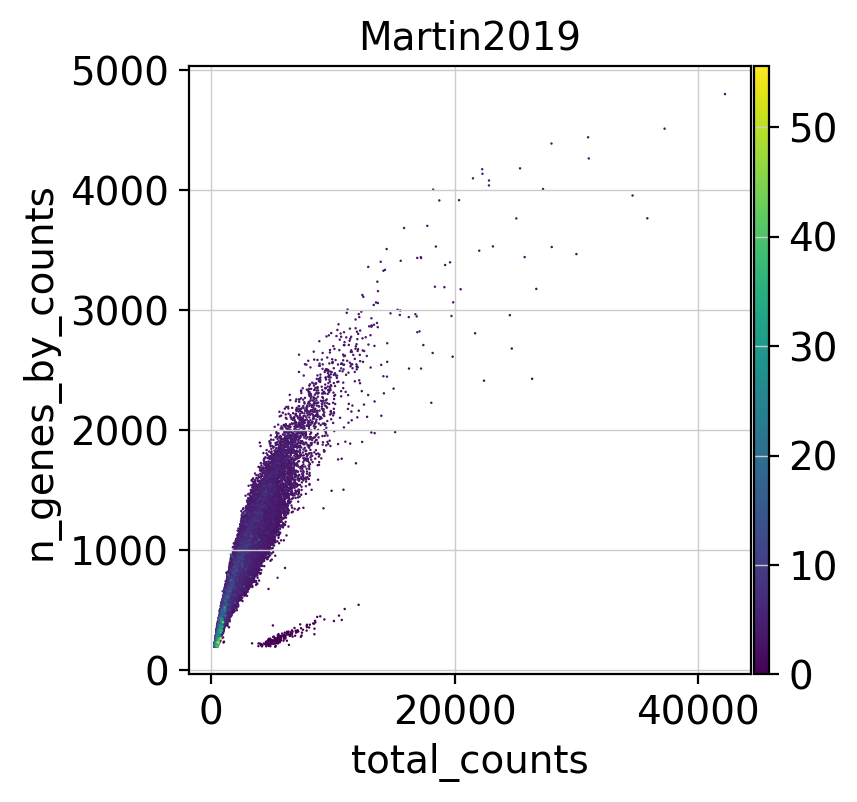

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

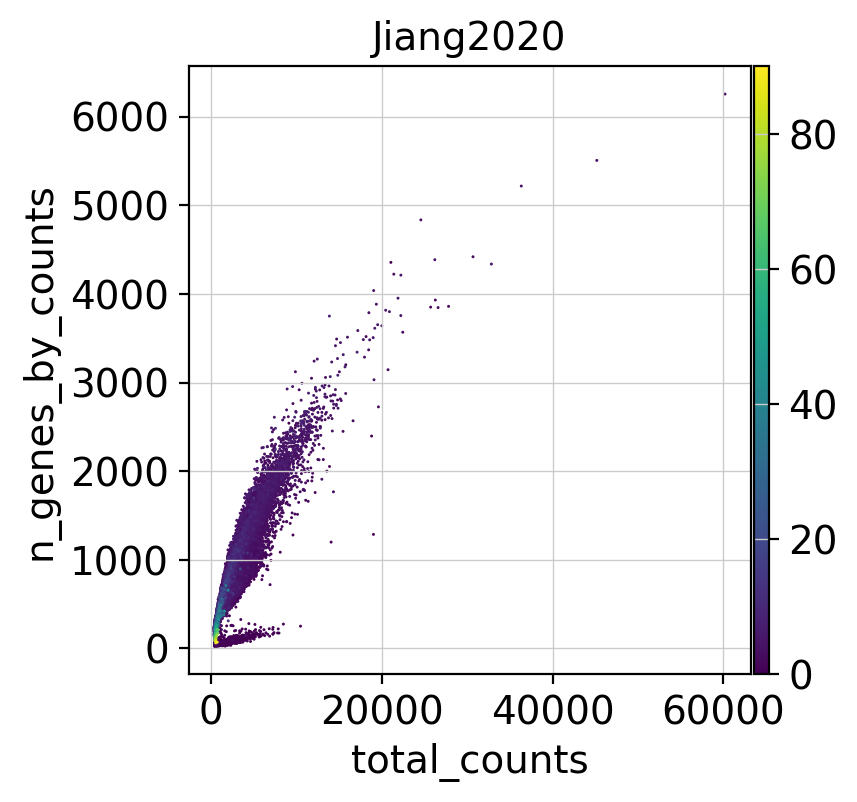

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [17]:
for s in adata.obs.studyID.unique():
    
    sc.pl.scatter(adata[adata.obs.studyID == s, :],
                  "total_counts", "n_genes_by_counts", color="pct_counts_mt", title=s)
    
    if overwriteFigures:
        plt.savefig(here(f"01_data_processing/figures/02_QCexternal_joinmetrics_{s}.pdf"), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
        
    plt.show()    

## Filter out low quality cells

According to the previous results, we have decided to apply different thresholds according to technology. Basically, cell barcodes with a low count depth, few detected genes, and a high fraction of mitochondrial counts could be indicative of lysed cells; therefore, we will proceed to filter them out.

In [18]:
# QC thresholds

cell_qc_thresholds = {
    "3_GEX_V3": {
        "min_libsize": 500,
        "max_libsize": 50000,        
        "min_libcomplex": 250,
        "max_libcomplex": 6000,
        "max_pctmt": 25
    },
    "3_GEX_V2": {
        "min_libsize": 500,
        "max_libsize": 25000,        
        "min_libcomplex": 250,
        "max_libcomplex": 4000,
        "max_pctmt": 20
    },
    "5_GEX_V2": {
        "min_libsize": 500,
        "max_libsize": 40000,        
        "min_libcomplex": 250,
        "max_libcomplex": 6000,
        "max_pctmt": 20
    },
    "5_GEX_V1": {
        "min_libsize": 500,
        "max_libsize": 50000,        
        "min_libcomplex": 250,
        "max_libcomplex": 6000,
        "max_pctmt": 20
    }
}

In [19]:
# Filter based on "chemistry" column
keepIDX = []

for chem_type, filter_params in cell_qc_thresholds.items():
    chem_filter = adata.obs["chemistry"] == chem_type
    chem_filter &= adata.obs["total_counts"] > filter_params["min_libsize"]
    chem_filter &= adata.obs["total_counts"] < filter_params["max_libsize"]
    chem_filter &= adata.obs["n_genes_by_counts"] > filter_params["min_libcomplex"]
    chem_filter &= adata.obs["n_genes_by_counts"] < filter_params["max_libcomplex"]
    chem_filter &= adata.obs["pct_counts_mt"] < filter_params["max_pctmt"]

    keepIDX += adata.obs.loc[chem_filter].index.tolist()

    # adata.append(adata[chem_filter])
    
adata = adata[adata.obs.index.isin(keepIDX)]
adata

View of AnnData object with n_obs × n_vars = 572872 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'chemistry_colors'

**General statistics AFTER cell QC**

In [20]:
pd.set_option('display.max_rows', None)
qc_gex_df = qc_gex_projectlibrary(adata)
display(qc_gex_df)

pd.reset_option('display.max_rows')

libraryID   chemistry  Number of cells  Median UMI counts  \
0        (10XGenomics_L000,)  [3_GEX_V3]             3775               7634   
1        (10XGenomics_L001,)  [3_GEX_V3]             4161               4745   
2        (10XGenomics_L002,)  [3_GEX_V3]             3113               7344   
3        (10XGenomics_L003,)  [3_GEX_V3]             3883               5954   
4        (10XGenomics_L004,)  [3_GEX_V3]             4680               5828   
5        (10XGenomics_L005,)  [3_GEX_V3]            23398               6591   
6        (10XGenomics_L006,)  [3_GEX_V3]            11272               6187   
7        (10XGenomics_L007,)  [3_GEX_V3]            11720               6971   
8        (10XGenomics_L008,)  [5_GEX_V2]            23226               4870   
9          (Jiang2020_L000,)  [3_GEX_V2]             4198               2394   
10         (Jiang2020_L001,)  [3_GEX_V2]             3556               2316   
11         (Jiang2020_L002,)  [3_GEX_V2]             2099               2909   
12         (Jiang2020_L003,)  [3_GEX_V2]             3977               2991   
13         (Jiang2020_L004,)  [3_GEX_V2]             3440               3146   
14         (Jiang2020_L005,)  [3_GEX_V2]             3880               3707   
15         (Jiang2020_L006,)  [3_GEX_V2]             4107               2895   
16        (Martin2019_L000,)  [3_GEX_V2]             2178               2327   
17        (Martin2019_L001,)  [3_GEX_V2]             1015               3342   
18        (Martin2019_L002,)  [3_GEX_V2]             1352               2540   
19        (Martin2019_L003,)  [3_GEX_V2]             3056               3096   
20        (Martin2019_L004,)  [3_GEX_V2]             4546               3019   
21        (Martin2019_L005,)  [3_GEX_V2]             6212               2004   
22        (Martin2019_L006,)  [3_GEX_V2]            13801               2748   
23        (Martin2019_L007,)  [3_GEX_V2]             5274               3066   
24        (Mistry2019_L000,)  [3_GEX_V2]             7724               1997   
25        (Mistry2019_L001,)  [3_GEX_V2]             8321               1609   
26        (Mistry2019_L002,)  [3_GEX_V2]             7913               2643   
27     (Palshikar2022_L000,)  [3_GEX_V2]            12640               2604   
28  (Ramachandran2019_L000,)  [3_GEX_V2]             8913               3054   
29  (Ramachandran2019_L001,)  [3_GEX_V2]             6622               2849   
30  (Ramachandran2019_L002,)  [3_GEX_V2]             8134               3081   
31  (Ramachandran2019_L003,)  [3_GEX_V2]             7048               4020   
32         (SCGT00val_L000,)  [3_GEX_V3]            27595               3885   
33         (SCGT00val_L001,)  [3_GEX_V3]            28209               3753   
34         (SCGT00val_L002,)  [3_GEX_V3]            25283               4340   
35         (SCGT00val_L003,)  [3_GEX_V3]            26062               4343   
36         (SCGT00val_L004,)  [3_GEX_V3]            29102               3796   
37         (SCGT00val_L005,)  [3_GEX_V3]            26698               3855   
38         (SCGT00val_L006,)  [3_GEX_V3]            27277               3789   
39         (SCGT00val_L007,)  [3_GEX_V3]            25849               3598   
40            (SCGT06_L000,)  [3_GEX_V3]            24402               4129   
41            (SCGT06_L001,)  [3_GEX_V3]            37973               3133   
42        (Savage2021_L000,)  [3_GEX_V3]             8734               6729   
43        (Savage2021_L001,)  [3_GEX_V3]             9065               6607   
44        (Savage2021_L002,)  [3_GEX_V3]             9368               6476   
45        (Savage2021_L003,)  [3_GEX_V3]             9496               7589   
46        (Savage2021_L004,)  [3_GEX_V3]             9059               7155   
47        (Savage2021_L005,)  [3_GEX_V3]             9127               6987   
48        (Savage2021_L006,)  [3_GEX_V3]            10853               7386   
49        (Savage20

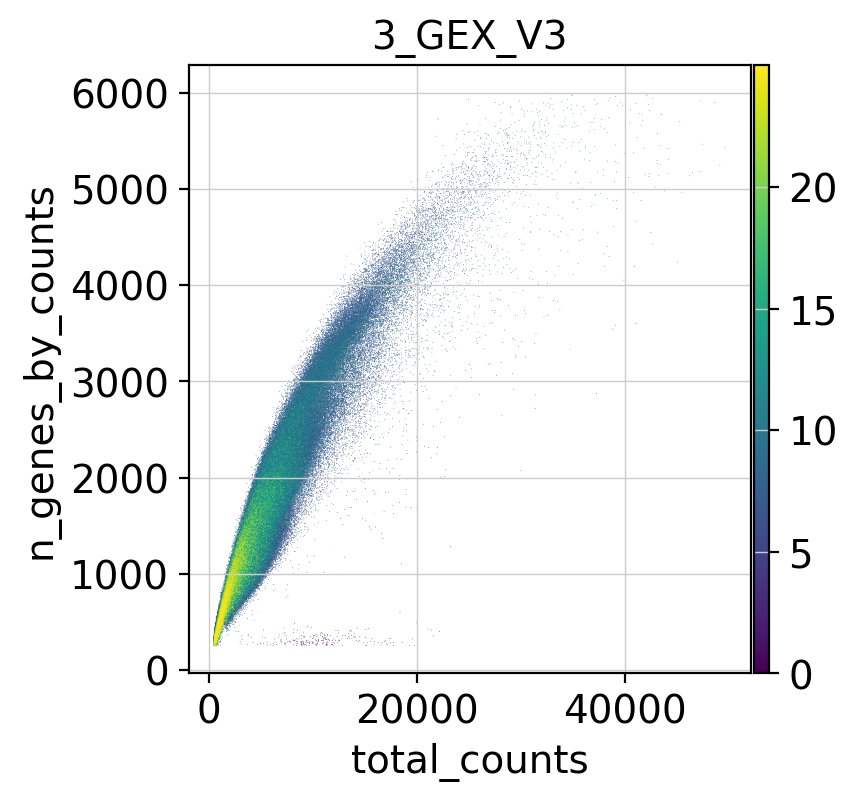

<Figure size 400x400 with 0 Axes>

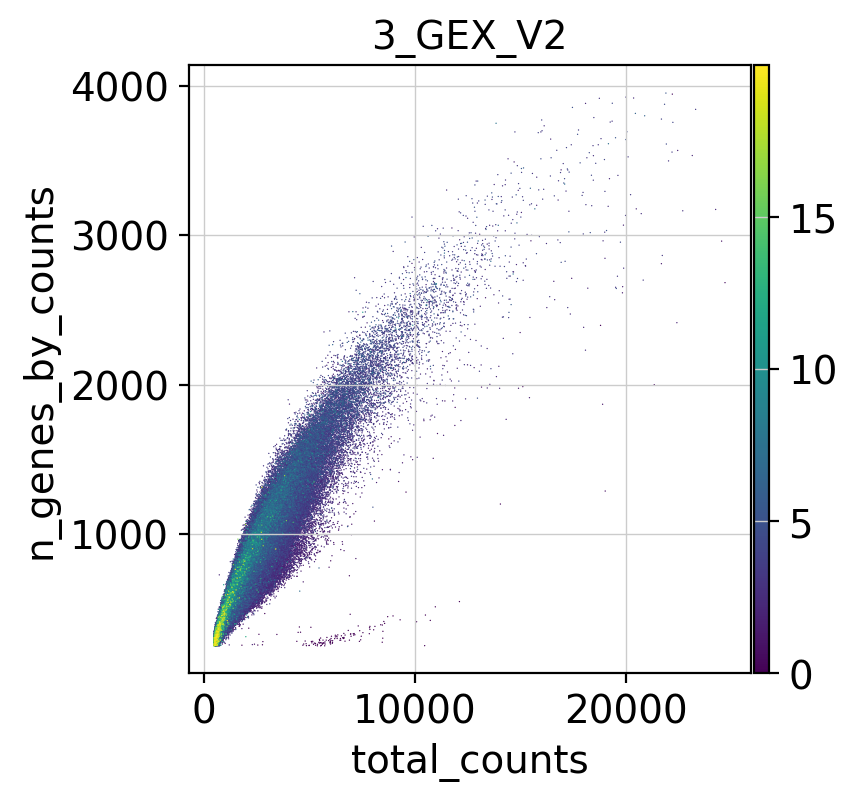

<Figure size 400x400 with 0 Axes>

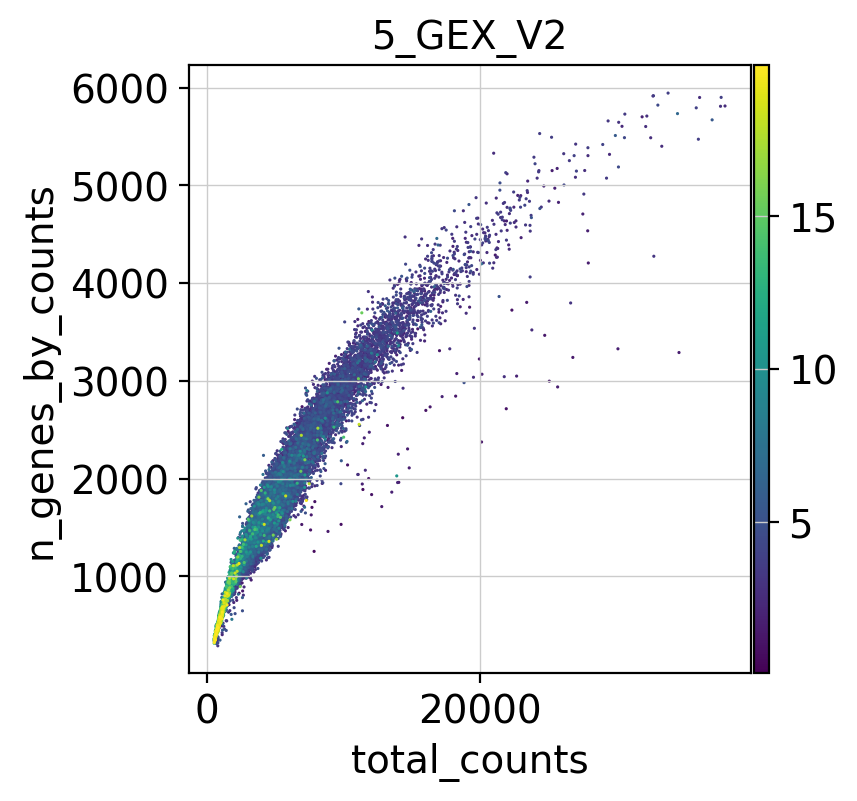

<Figure size 400x400 with 0 Axes>

In [21]:
cellIdx = (adata.obs.chemistry == "3_GEX_V3")
if np.sum(cellIdx) > 0:
    sc.pl.scatter(adata[cellIdx, :],
                  "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="3_GEX_V3")
    if overwriteFigures:
        plt.savefig(here('01_data_processing/figures/02_QCexternal_joinmetrics_3GEXV3_afterFiltering.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    plt.show()
    
cellIdx = (adata.obs.chemistry == "3_GEX_V2")
if np.sum(cellIdx) > 0:
    sc.pl.scatter(adata[cellIdx, :],    
                  "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="3_GEX_V2")
    if overwriteFigures:
        plt.savefig(here('01_data_processing/figures/02_QCexternal_joinmetrics_3GEXV2_afterFiltering.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    plt.show()
    
cellIdx = (adata.obs.chemistry == "5_GEX_V2")
if np.sum(cellIdx) > 0:
    sc.pl.scatter(adata[cellIdx, :],    
                  "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="5_GEX_V2")
    if overwriteFigures:
        plt.savefig(here('01_data_processing/figures/02_QCexternal_joinmetrics_5GEXV2_afterFiltering.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    plt.show()
    
cellIdx = (adata.obs.chemistry == "5_GEX_V1")
if np.sum(cellIdx) > 0:
    sc.pl.scatter(adata[cellIdx, :],    
                  "total_counts", "n_genes_by_counts", color="pct_counts_mt", title="5_GEX_V1")
    if overwriteFigures:
        plt.savefig(here('01_data_processing/figures/02_QCexternal_joinmetrics_5GEXV1_afterFiltering.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
    plt.show()

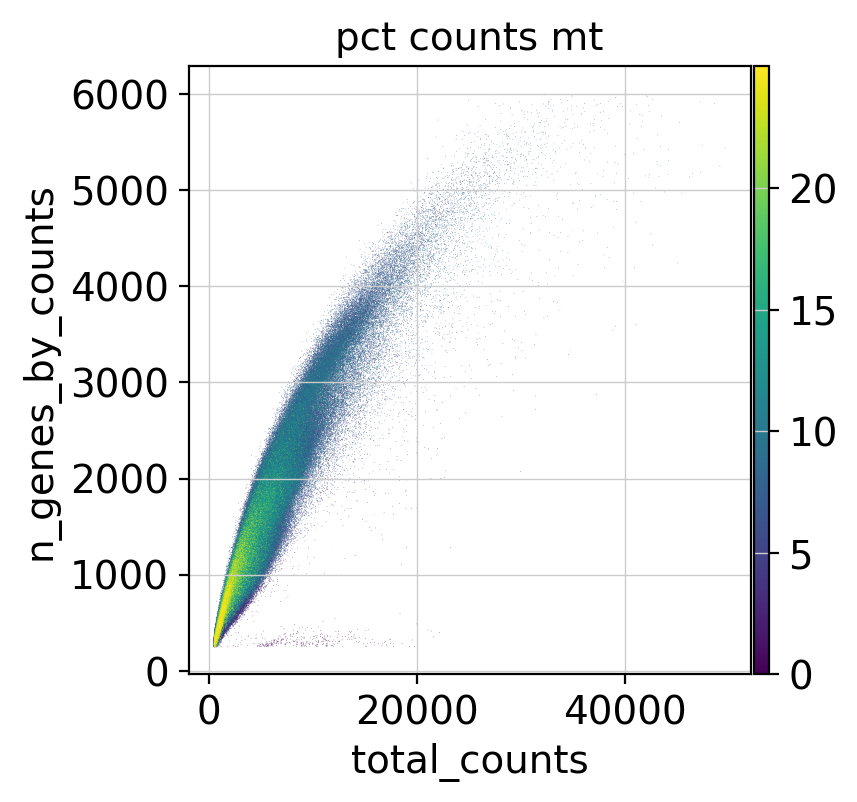

<Figure size 400x400 with 0 Axes>

In [22]:
# Now, the whole dataset
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

if overwriteFigures:
    plt.savefig(here('01_data_processing/figures/02_QCexternal_joinmetrics_allDatasets_afterFiltering.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)
plt.show()

# Quality Control at (LIBRARY) & SAMPLE level

After exploring general library QC metrics, we decided to filter out the samples with very low number of cells, considering patient & timepoint, since some samples have been sequenced across multiple 10X libraries.

Also, after removing low quality cells, we ensure that there are now no low-quality library after removing low-quality cells, which would indicate low-quality library quality preparation and lead to a large batch-effect.

Lastly, we are removing cells that were captured in specific sample/library when the total number of cells belonging to this patient is smaller than 50 cells.

In [23]:
# QC thresholds
min_cells_by_sample = 500
min_meangenes_by_sample = 500
min_cells_by_samplelibrarypatient = 50

## Filter out low quality libraries

In [24]:
# Removing libraries with very low total number of cells (after cellQC)
min_cells_by_lib = 250

# Calculate the value counts for each 'libraryID'
library_cells = adata.obs["libraryID"].value_counts()

# Get the library names to remove
libraries_to_remove = library_cells[library_cells < min_cells_by_lib].index

if len(libraries_to_remove) > 0:
    print('Libraries removed:')
    print(libraries_to_remove.astype(str))

    # Filter the 'adata' object
    adata = adata[~adata.obs["libraryID"].isin(libraries_to_remove.astype(str))]
else:
    print('No library is removed')

No library is removed


## Filter out low quality samples

In [25]:
# Removing samples (patient & timepoint) with very low total number of cells

# Calculate the value counts for each 'sampleID'
sample_cells = adata.obs["sampleID"].value_counts()

# Get the sample names to remove
samples_to_remove = sample_cells[sample_cells < min_cells_by_sample].index

if len(samples_to_remove) > 0:
    print('Samples removed:')
    print(samples_to_remove.astype(str))

    # Filter the 'adata' object
    adata = adata[~adata.obs["sampleID"].isin(samples_to_remove.astype(str))]
else:
    print('No sample is removed')

No sample is removed


In [26]:
# Removing samples with very low median number of total genes

# Calculate the median total counts for each 'sampleID'
sample_median_counts = adata.obs.groupby("sampleID")["n_genes_by_counts"].median()

# Get the sample names with median "total_counts" fewer than 500
libraries_to_remove = sample_median_counts[sample_median_counts < min_meangenes_by_sample].index

if len(libraries_to_remove) > 0:
    print('Samples removed:')
    print(libraries_to_remove.astype(str))

    # Filter the 'adata' object
    adata = adata[~adata.obs["sampleID"].isin(libraries_to_remove.astype(str))]
else:
    print('No sample is removed')

No sample is removed


## Filtering cells from low quality samples / library by patient

In [27]:
samplelibpatients_cells = adata.obs[["sampleID", "libraryID", "patientID"]].value_counts().sort_values(ascending=True)
samplelibpatients_cells.head()

sampleID              libraryID           patientID        
Martin2019_P7_T0      Martin2019_L001     Martin2019_P7        1015
Martin2019_P8_T0      Martin2019_L002     Martin2019_P8        1352
Palshikar2022_P07_T0  Palshikar2022_L000  Palshikar2022_P07    1398
Palshikar2022_P05_T0  Palshikar2022_L000  Palshikar2022_P05    1442
Palshikar2022_P03_T0  Palshikar2022_L000  Palshikar2022_P03    1469
Name: count, dtype: int64

In [28]:
# Removing CELLS (sample & library & patient) with very low total number of cells

# Calculate the value counts
samplelibpatients_cells = adata.obs[["sampleID", "libraryID", "patientID"]].value_counts().sort_values(ascending=True)

if samplelibpatients_cells.min() <= min_cells_by_samplelibrarypatient: 
    # Get the sample names to remove
    cells_to_remove_df = samplelibpatients_cells[samplelibpatients_cells < min_cells_by_samplelibrarypatient]
    
    cells_to_remove_df = pd.DataFrame(cells_to_remove_df.reset_index())
    cells_to_remove_df["libraryID"] = cells_to_remove_df["libraryID"].astype(str)
    cells_to_remove_df["sampleID"] = cells_to_remove_df["sampleID"].astype(str)
    cells_to_remove_df['startwith_cellID'] = cells_to_remove_df["libraryID"] + '_' + cells_to_remove_df["sampleID"].str.split("_", expand=True)[1] + '_' + cells_to_remove_df["sampleID"].str.split("_", expand=True)[2]

    if len(cells_to_remove_df) > 0:
    
        cellID_to_remove = [cell_id for cell_id in adata.obs_names if any(cell_id.startswith(startwith) 
                                 for startwith in cells_to_remove_df["startwith_cellID"])]
        print('Cells from samples/library/patient removed:')
        print(len(cellID_to_remove))
        print(cellID_to_remove)
    
        # Filter the 'adata' object
        adata = adata[~adata.obs_names.isin(cellID_to_remove)]
else:
    print('No cells from samples/library/patient are removed.')

No cells from samples/library/patient are removed.


In [29]:
adata

View of AnnData object with n_obs × n_vars = 572872 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'chemistry_colors'

In [30]:
len(adata.obs["sampleID"].unique())

86

# Save results

In [31]:
# Save Anndata object (.h5ad file) 
adata.write(here("01_data_processing/results/02_INFLAMMATION_external_afterQC.h5ad"), compression="gzip")
del adata

In [32]:
session_info.show()